<a href="https://colab.research.google.com/github/jhtwiz/AI-1-jhtwiz/blob/main/2%EC%A3%BC%EC%B0%A8_%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.
Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 34.0 MB/s eta 0:00:00


In [3]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Self-attention

이번에는 self-attention을 구현해보겠습니다.
Self-attention은 shape이 (B, S, D)인 embedding이 들어왔을 때 attention을 적용하여 새로운 representation을 만들어내는 module입니다.
여기서 B는 batch size, S는 sequence length, D는 embedding 차원입니다.
구현은 다음과 같습니다.

In [4]:
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
  def __init__(self, input_dim, d_model, n_heads):
    super().__init__()
    assert d_model % n_heads == 0

    self.input_dim = input_dim
    self.d_model = d_model # D
    self.n_heads = n_heads # H
    self.head_dim = d_model // n_heads # D/H


    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    batch_size = x.shape[0] # B
    seq_length = x.shape[1] # S

    q, k, v = self.wq(x), self.wk(x), self.wv(x) # (B, S, D)
    q = q.view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2) # (B, S, D) -> (B, S, H, D/H) -> (B, H, S, D/H)
    k = k.view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2) # (B, S, D) -> (B, S, H, D/H) -> (B, H, S, D/H)
    v = v.view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2) # (B, S, D) -> (B, S, H, D/H) -> (B, H, S, D/H)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, H, S, D/H) * (B, H, D/H, S) = (B, H, S, S)
    score = score / sqrt(self.head_dim) # sqrt(D/H)

    if mask is not None:
      # mask 차원 추가는 TextClassifier에 적용했습니다
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v) # (B, H, S, S) * (B, H, S, D/H) = (B, H, S, D/H)
    result = result.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model) # (B, H, S, D/H) -> (B, S, D)
    result = self.dense(result)

    return result

대부분은 Transformer 챕터에서 배운 수식들을 그대로 구현한 것에 불과합니다.
차이점은 `mask`의 존재여부입니다.
이전 챕터에서 우리는 가변적인 text data들에 padding token을 붙여 하나의 matrix로 만든 방법을 배웠습니다.
실제 attention 계산에서는 이를 무시해주기 위해 mask를 만들어 제공해주게 됩니다.
여기서 mask의 shape은 (B, S, 1)로, 만약 `mask[i, j] = True`이면 그 변수는 padding token에 해당한다는 뜻입니다.
이러한 값들을 무시해주는 방법은 shape이 (B, S, S)인 `score`가 있을 때(수업에서 배운 $A$와 동일) `score[i, j]`에 아주 작은 값을 더해주면 됩니다. 아주 작은 값은 예를 들어 `-1000..00 = -1e9` 같은 것이 있습니다.
이렇게 작은 값을 더해주고 나면 softmax를 거쳤을 때 0에 가까워지기 때문에 weighted sum 과정에서 padding token에 해당하는 `v` 값들을 무시할 수 있게 됩니다.

다음은 self-attention과 feed-forward layer를 구현한 모습입니다.

In [5]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, n_heads, dff, p_dropout):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.MHA = MultiHeadAttention(input_dim, d_model, n_heads)
    self.FFN = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )
    self.dropout = nn.Dropout(p_dropout)
    self.layerNorm1 = nn.LayerNorm(d_model)
    self.layerNorm2 = nn.LayerNorm(d_model)

  def forward(self, x, mask):
    MHA = self.dropout(self.MHA(x, mask)) # MHA with dropout
    x = self.layerNorm1(x + MHA) # residual connection(Add+Norm)

    FFN = self.dropout(self.FFN(x)) # FFN with dropout
    x = self.layerNorm2(x + FFN) # residual connection(Add+Norm)

    return x

보시다시피 self-attention의 구현이 어렵지, Transformer layer 하나 구현하는 것은 수업 때 다룬 그림과 크게 구분되지 않는다는 점을 알 수 있습니다.

## Positional encoding

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [6]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

In [7]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_heads, n_layers, dff, p_dropout = 0.1):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, n_heads, dff, p_dropout) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 4, 5, 32) # 5-layer-4-head

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

## 학습

학습하는 코드는 기존 실습들과 동일하기 때문에 마지막 결과만 살펴보도록 하겠습니다.

In [8]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

    preds = model(inputs)[..., 0]
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 205.75434911251068
=========> Train acc: 0.806 | Test acc: 0.781
Epoch   1 | Train Loss: 139.153679266572
=========> Train acc: 0.885 | Test acc: 0.831
Epoch   2 | Train Loss: 110.80936393886805
=========> Train acc: 0.919 | Test acc: 0.830
Epoch   3 | Train Loss: 88.71731460094452
=========> Train acc: 0.939 | Test acc: 0.834
Epoch   4 | Train Loss: 68.72550412267447
=========> Train acc: 0.970 | Test acc: 0.837
Epoch   5 | Train Loss: 51.73945987038314
=========> Train acc: 0.973 | Test acc: 0.833
Epoch   6 | Train Loss: 41.98376879282296
=========> Train acc: 0.982 | Test acc: 0.828
Epoch   7 | Train Loss: 30.318384103477
=========> Train acc: 0.987 | Test acc: 0.828
Epoch   8 | Train Loss: 26.358080498408526
=========> Train acc: 0.984 | Test acc: 0.818
Epoch   9 | Train Loss: 22.82420944655314
=========> Train acc: 0.991 | Test acc: 0.824
Epoch  10 | Train Loss: 20.03028242243454
=========> Train acc: 0.993 | Test acc: 0.828
Epoch  11 | Train Loss: 16.85240

학습이 안정적으로 진행되며 RNN보다 빨리 수렴하는 것을 확인할 수 있습니다.
하지만 test 정확도가 RNN보다 낮은 것을 보았을 때, overfitting에 취약하다는 것을 알 수 있습니다.

**이 부분 부터는 과제 외 부분입니다.**

In [10]:
#앞선 결과가 너무 빠른 수렴을 보여서 일단 20 epoch을 기본으로 함
def train(model, optimizer, trainloader, testloader, n_epochs = 20):
    train_acc = []
    test_acc = []
    for epoch in range(n_epochs):
        total_loss = 0.
        model.train()
        for data in trainloader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

            preds = model(inputs)[..., 0]
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

        with torch.no_grad():
            model.eval()
            acc_train = accuracy(model, trainloader)
            acc_test = accuracy(model, testloader)
            train_acc.append(acc_train)
            test_acc.append(acc_test)
            print(f"=========> Train acc: {acc_train:.3f} | Test acc: {acc_test:.3f}")

    return train_acc, test_acc

In [ ]:
#overfitting이 있는거로 보여서 dropout 올려서 테스트
model_d_2 = TextClassifier(len(tokenizer), 32, 4, 5, 32, 0.2) # dropout 0.2
model_d_2 = model_d_2.to('cuda')
optimizer_d_2 = Adam(model_d_2.parameters(), lr=lr)

model_d_3 = TextClassifier(len(tokenizer), 32, 4, 5, 32, 0.3) # dropout 0.3
model_d_3 = model_d_3.to('cuda')
optimizer_d_3 = Adam(model_d_3.parameters(), lr=lr)

In [ ]:
train_d_2, test_d_2 = train(model_d_2, optimizer_d_2, train_loader, test_loader)
train_d_3, test_d_3 = train(model_d_3, optimizer_d_3, train_loader, test_loader)

Epoch   0 | Train Loss: 215.84313693642616
=========> Train acc: 0.822 | Test acc: 0.790
Epoch   1 | Train Loss: 152.29524511098862
=========> Train acc: 0.876 | Test acc: 0.821
Epoch   2 | Train Loss: 119.22076657414436
=========> Train acc: 0.913 | Test acc: 0.832
Epoch   3 | Train Loss: 97.21981474012136
=========> Train acc: 0.940 | Test acc: 0.836
Epoch   4 | Train Loss: 75.1757870875299
=========> Train acc: 0.958 | Test acc: 0.827
Epoch   5 | Train Loss: 56.30418869107962
=========> Train acc: 0.971 | Test acc: 0.824
Epoch   6 | Train Loss: 42.92033953405917
=========> Train acc: 0.965 | Test acc: 0.818
Epoch   7 | Train Loss: 32.28139325417578
=========> Train acc: 0.988 | Test acc: 0.826
Epoch   8 | Train Loss: 26.76229409314692
=========> Train acc: 0.979 | Test acc: 0.821
Epoch   9 | Train Loss: 21.369790002238005
=========> Train acc: 0.990 | Test acc: 0.822
Epoch  10 | Train Loss: 18.566245357738808
=========> Train acc: 0.993 | Test acc: 0.824
Epoch  11 | Train Loss: 17.8

In [12]:
from matplotlib import pyplot as plt

def showPlot(*results):
    for result in results:
        data = result['data']
        label = result['label']
        x = np.arange(len(data))
        plt.plot(x, data, label=label)
    plt.xticks(np.arange(0, len(data), step=1))
    plt.legend()
    plt.show()

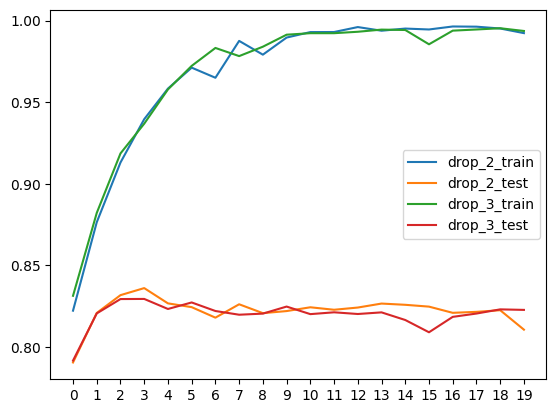

In [ ]:
showPlot({'label': 'drop_2_train', 'data': train_d_2}, {'label': 'drop_2_test', 'data': test_d_2},{'label': 'drop_3_train', 'data': train_d_3}, {'label': 'drop_3_test', 'data': test_d_3})

**dropout을 올려도 3~4 epoch으로 이미 test의 정확도 증가는 멈췄고 더 아는 개선책이 없어서 overfitting의 해결에 대한 방안은 추후 생각하고 d_model과 dff를 조절해서 어떻게 변하는지 확인해볼 예정. 느낌상으로는 d_model이 올라가면 embedding 차원이 올라가기 때문에 단어를 더 자세히 표현할 수 있는것 같고 dff를 높이면 layer의 node수가 많아지니 더 잘 분석할 수 있지 않을까?**

In [ ]:
#embedding 차원(d_model)과 dff를 높여서 테스트
model_128 = TextClassifier(len(tokenizer), 64, 4, 5, 128) # d_model = 64, dff = 128 dropout = 0.1
model_128 = model_128.to('cuda')
optimizer_128 = Adam(model_128.parameters(), lr=lr)

model_128_d_2 = TextClassifier(len(tokenizer), 64, 4, 5, 128, 0.2) # d_model = 64, dff = 128 dropout = 0.2
model_128_d_2 = model_128_d_2.to('cuda')
optimizer_128_d_2 = Adam(model_128_d_2.parameters(), lr=lr)

In [ ]:
#epoch은 10으로 더 낮춰도 될거 같음
train_128, test_128 = train(model_128, optimizer_128, train_loader, test_loader, 10)
train_128_d_2, test_128_d_2 = train(model_128_d_2, optimizer_128_d_2, train_loader, test_loader, 10)

Epoch   0 | Train Loss: 138.51318258047104
=========> Train acc: 0.882 | Test acc: 0.826
Epoch   1 | Train Loss: 118.3451645821333
=========> Train acc: 0.899 | Test acc: 0.837
Epoch   2 | Train Loss: 104.11272569000721
=========> Train acc: 0.927 | Test acc: 0.841
Epoch   3 | Train Loss: 90.35982226580381
=========> Train acc: 0.936 | Test acc: 0.842
Epoch   4 | Train Loss: 83.93071288615465
=========> Train acc: 0.949 | Test acc: 0.844
Epoch   5 | Train Loss: 72.90088400617242
=========> Train acc: 0.957 | Test acc: 0.843
Epoch   6 | Train Loss: 63.512849101796746
=========> Train acc: 0.959 | Test acc: 0.839
Epoch   7 | Train Loss: 59.355236465111375
=========> Train acc: 0.953 | Test acc: 0.825
Epoch   8 | Train Loss: 53.17296074330807
=========> Train acc: 0.970 | Test acc: 0.839
Epoch   9 | Train Loss: 46.50120867229998
=========> Train acc: 0.977 | Test acc: 0.840
Epoch   0 | Train Loss: 204.58716121315956
=========> Train acc: 0.847 | Test acc: 0.811
Epoch   1 | Train Loss: 142

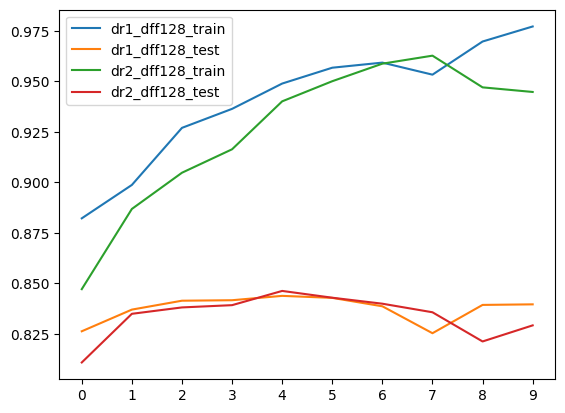

In [ ]:
showPlot({'label': 'dr1_dff128_train', 'data': train_128}, {'label': 'dr1_dff128_test', 'data': test_128},{'label': 'dr2_dff128_train', 'data': train_128_d_2}, {'label': 'dr2_dff128_test', 'data': test_128_d_2})

In [ ]:
#dropout = 0.2로 고정하고 d_model과 dff를 더 높여서 테스트.
model_256 = TextClassifier(len(tokenizer), 128, 4, 5, 256, 0.2) # d_model = 128, dff = 256
model_256 = model_256.to('cuda')
optimizer_256 = Adam(model_256.parameters(), lr=lr)

model_512 = TextClassifier(len(tokenizer), 256, 4, 5, 512, 0.2) # d_model = 256, dff = 512
model_512 = model_512.to('cuda')
optimizer_512 = Adam(model_512.parameters(), lr=lr)

train_256, test_256 = train(model_256, optimizer_256, train_loader, test_loader, 10)
train_512, test_512 = train(model_512, optimizer_512, train_loader, test_loader, 10)

Epoch   0 | Train Loss: 205.64808797836304
=========> Train acc: 0.827 | Test acc: 0.799
Epoch   1 | Train Loss: 156.42082831263542
=========> Train acc: 0.857 | Test acc: 0.824
Epoch   2 | Train Loss: 140.74193108081818
=========> Train acc: 0.878 | Test acc: 0.834
Epoch   3 | Train Loss: 127.23169276118279
=========> Train acc: 0.891 | Test acc: 0.840
Epoch   4 | Train Loss: 121.75567570328712
=========> Train acc: 0.906 | Test acc: 0.845
Epoch   5 | Train Loss: 112.51802432537079
=========> Train acc: 0.904 | Test acc: 0.841
Epoch   6 | Train Loss: 106.52744753658772
=========> Train acc: 0.918 | Test acc: 0.845
Epoch   7 | Train Loss: 102.02263493090868
=========> Train acc: 0.890 | Test acc: 0.830
Epoch   8 | Train Loss: 98.42213721573353
=========> Train acc: 0.932 | Test acc: 0.845
Epoch   9 | Train Loss: 92.56346563994884
=========> Train acc: 0.934 | Test acc: 0.849
Epoch   0 | Train Loss: 276.44929468631744
=========> Train acc: 0.523 | Test acc: 0.520
Epoch   1 | Train Loss:

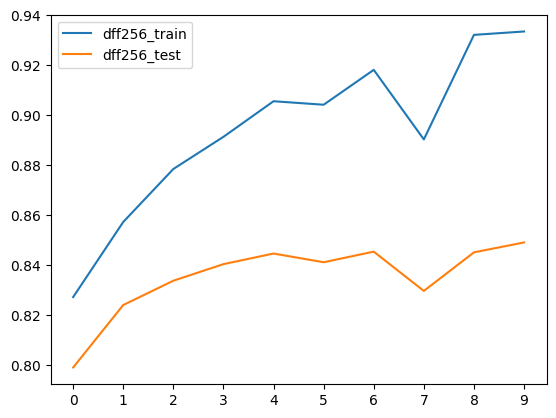

In [ ]:
showPlot({'label': 'dff256_train', 'data': train_256}, {'label': 'dff256_test', 'data': test_256})

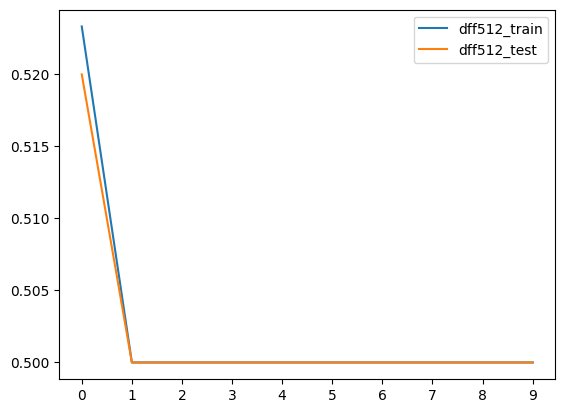

In [ ]:
showPlot({'label': 'dff512_train', 'data': train_512}, {'label': 'dff512_test', 'data': test_512})

**d_model=256, dff=512로 놓으니 아예 학습이 안되는 모습이 보임. 신기함. 이정도까지 늘리면 원래 안되는건지? 뭐를 잘못한건지 확인 필요.**

In [11]:
#마지막으로 이전에 했던 설정들 중 결과가 나쁘지 않았던거로 20에폭까지 돌려보기
model_last = TextClassifier(len(tokenizer), 128, 4, 5, 256, 0.2) # d_model = 128, dff = 256
model_last = model_last.to('cuda')
optimizer_last = Adam(model_last.parameters(), lr=lr)

train_last, test_last = train(model_last, optimizer_last, train_loader, test_loader, 20)

Epoch   0 | Train Loss: 210.2106246203184
=========> Train acc: 0.786 | Test acc: 0.774
Epoch   1 | Train Loss: 155.15329059958458
=========> Train acc: 0.860 | Test acc: 0.825
Epoch   2 | Train Loss: 136.3940550684929
=========> Train acc: 0.833 | Test acc: 0.789
Epoch   3 | Train Loss: 124.50053794682026
=========> Train acc: 0.900 | Test acc: 0.841
Epoch   4 | Train Loss: 116.29587624967098
=========> Train acc: 0.910 | Test acc: 0.849
Epoch   5 | Train Loss: 109.70340050011873
=========> Train acc: 0.905 | Test acc: 0.834
Epoch   6 | Train Loss: 104.27218789607286
=========> Train acc: 0.921 | Test acc: 0.846
Epoch   7 | Train Loss: 99.17635861039162
=========> Train acc: 0.906 | Test acc: 0.838
Epoch   8 | Train Loss: 92.93513681739569
=========> Train acc: 0.929 | Test acc: 0.848
Epoch   9 | Train Loss: 88.44030655920506
=========> Train acc: 0.935 | Test acc: 0.846
Epoch  10 | Train Loss: 82.63962521404028
=========> Train acc: 0.936 | Test acc: 0.837
Epoch  11 | Train Loss: 79.

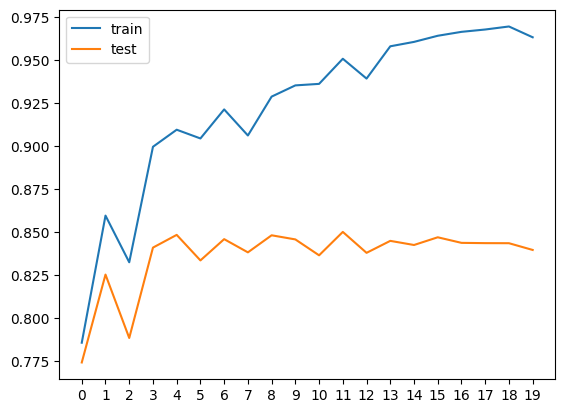

In [13]:
showPlot({'label': 'train', 'data': train_last}, {'label': 'test', 'data': test_last})